# Part 1: Data Analysis

## Import Libraries and Load data

In [210]:
import sys,os,signal

import numpy as np
import musicnet

import random

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss
import torch.nn as nn

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

from python_speech_features import mfcc

root = './musicnet'

%matplotlib inline

import pretty_midi
import librosa, librosa.display


import IPython.display as ipd


import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
from NADE_mine.model import NADE
from python_speech_features import mfcc
from torch.autograd import Variable
import musicnet
import sys, os, signal
import numpy as np
from time import time
from IPython.display import Audio


The code for loading the data come from : https://github.com/jthickstun/pytorch_musicnet/blob/master/musicnet_module.ipynb

In [2]:
m = 128 ## second dimension of y : maximum number of note : quelquel note on entend dans cette extrait ?
k = 500
d = 4096

window = 16384
stride = 512
regions = 1 + (window - d)//stride


def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 0, 'pin_memory': True, 'worker_init_fn': worker_init}

train_set = musicnet.MusicNet(root=root, train=True, download=True,normalize =False, window=window)
test_set = musicnet.MusicNet(root=root, train=False,normalize =False, window=window, epoch_size=50000)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

### Load the ConvNet model

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1, padding=1),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=1, stride=1, padding=1),
            nn.ReLU())
        
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(84*310+8, 50)
        self.fc2 = nn.Linear(50, 128)
    def forward(self, x):
        val = x[:,None,:,:]
        out = self.layer1(val)
        out = self.layer2(out)
        #print('avant : ',out.size())
        out = out.reshape(out.size(0), -1)
        #print('après : ',out.size())
        out = self.drop_out(out)
        #print('après dropout : ',out.size())
        out = self.fc1(out)
        #print('après fc1 : ',out.size())
        out = self.fc2(out)
        #print('après fc2: ',out.size())
        return out

## Check the cuda version and if it is available

In [4]:
print(torch.version.cuda)  
print(torch.cuda.device_count())
print(torch.cuda.is_available())

10.1
1
True


### Load the NADE Model

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_NADE = NADE(input_dim=128, hidden_dim=50).to(device)
model_NADE.load_state_dict(torch.load("nade-binary.pt"))
model_NADE.eval()

NADE(
  (params): ParameterDict(
      (V): Parameter containing: [torch.cuda.FloatTensor of size 128x50 (GPU 0)]
      (W): Parameter containing: [torch.cuda.FloatTensor of size 50x128 (GPU 0)]
      (b): Parameter containing: [torch.cuda.FloatTensor of size 128 (GPU 0)]
      (c): Parameter containing: [torch.cuda.FloatTensor of size 1x50 (GPU 0)]
  )
)

### Load the accoustic model

In [83]:
model_accoustic = ConvNet().float()
model_accoustic.load_state_dict(torch.load("CNN-CQT-binary.pt"))
model_accoustic.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=26048, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=128, bias=True)
)

## Combining the two models

In [110]:
# Train the model
sr = 16384
total_step = len(train_loader)
loss_list = []
acc_list = []
num_epochs = 1
with train_set, test_set:
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(test_loader):
            inputs_y = y
            inputs_y = inputs_y.float().to(device)
            
            tab_C = np.array([np.abs(librosa.cqt(ele, sr=sr)) for ele in x.numpy()])
            tab_C = Variable(torch.from_numpy(tab_C).float(), requires_grad=False)
            
            print(model_NADE(inputs_y).shape)
            
            print(model_accoustic(tab_C).shape)
            break
        break
    

torch.Size([100, 128])
torch.Size([100, 128])


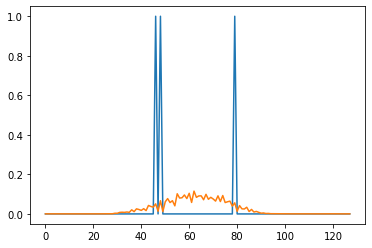

In [111]:
res_NADE = model_NADE(inputs_y)
plt.plot(inputs_y[7].cpu().detach().numpy())
plt.plot(res_NADE[7].cpu().detach().numpy())

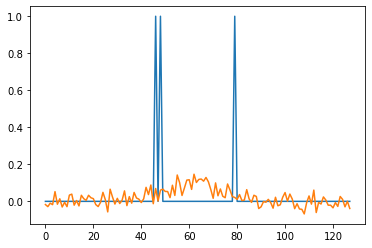

In [112]:
res_Accoustic = model_accoustic(tab_C)
plt.plot(inputs_y[7].cpu().detach().numpy())
plt.plot(res_Accoustic[7].cpu().detach().numpy())

5.4569682106375694e-12

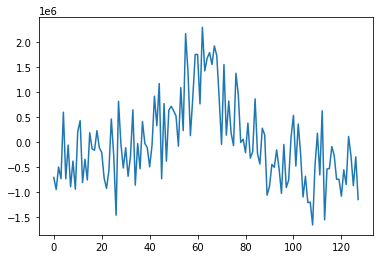

In [160]:
numpy_value = numpy_value/np.sum(numpy_value)
numpy_value = numpy_value - np.mean(numpy_value) * np.ones(128)
plt.plot(numpy_value)
numpy_value.mean()

### Define a function in order to get the most probable y from the accoustic model

5.116931296885014


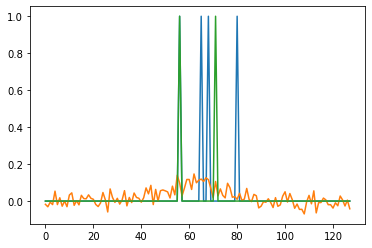

In [268]:
def get_next_most_probable(indice_most,nombre_value,numpy_tab_value):    
    
    sort_index = np.argsort(numpy_tab_value)[::-1] 
    tab_val = np.zeros(128)
    tab_inv_val = np.ones(128)
    proba = 0
    
    random_indices = random.choices(sort_index[0:nombre_value+K] , k=nombre_value )
    #print(random_indices)
    
    for ele in random_indices:
        next_indice = sort_index[i]
        tab_val[ele] = 1
        tab_inv_val[ele] = 0
        
    #print(tab_inv_val)
    #print(numpy_tab_value)
    proba = tab_val.dot(numpy_tab_value) + nombre_value * tab_inv_val.dot(numpy_tab_value)
    return tab_val, proba

numpy_value = res_Accoustic[6].cpu().detach().numpy()

tab_val, proba = get_next_most_probable(indice_most=0,nombre_value=2,numpy_tab_value=numpy_value)

print(proba)

plt.plot(inputs_y[6].cpu().detach().numpy())
plt.plot(numpy_value)
plt.plot(tab_val)

### Define  function to sort in regards to the log likelihood

In [269]:
def personal_sort(beam):
    
    log_likelihood_values = np.array([ ele[0] for ele in beam])
    
    sorted_log_values = np.argsort(log_likelihood_values)[::-1]
    
    array_beam = np.array(beam)
    
    sorted_beam = array_beam[sorted_log_values]
    
    return sorted_beam

## Compute the Beam search algorithm

In [270]:
## we have two parameters as we deals with chors : nombre_value and indice_most
num_chords_max = 6
K = 5

## we will store all the beam object here
beam = [(0,{},[])]

## s is a sequence of y_0
## l log likelyhood of s
## ma accoustic model
## ml language model
size_max = 5

## where the marginals P(yt) and priors P(y0), P(x0) are assumed to be ﬁxed w.r.t. the model parameters.
for i in range(batch_size):
    #print(i)
    # res accoustic contains P(y|x)
    tab_C = np.array([np.abs(librosa.cqt(ele, sr=sr)) for ele in x.numpy()])
    tab_C = Variable(torch.from_numpy(tab_C).float(), requires_grad=False)
    res_Accoustic = model_accoustic(tab_C)
    ## new beam will be the answer for the batch i
    new_beam = []
    for ele in beam:
        for j in range(1,num_chords_max):
            for k in range(K):
                #print(ele[2])
                list_to_predict_language = list(np.copy(ele[2]))
                # first create the next possible prediction
                numpy_value = res_Accoustic[i].cpu().detach().numpy()
                tab_val_y_accoustic,probability_y_x = get_next_most_probable(indice_most=k,nombre_value=j,numpy_tab_value=numpy_value)
                # add it to the previous value in order to compute a full epoch
                list_to_predict_language.append(tab_val_y_accoustic)
                # transform list into array
                matrix_to_predict_language = np.asarray(list_to_predict_language)
                # transform it into a readable format for torch
                matrix_to_predict_language = matrix_to_predict_language.reshape((-1,128))
                #print('size of matrix to predict language : ',matrix_to_predict_language.shape)
                # transform matrix 
                matrix_to_predict_language = Variable(torch.from_numpy(matrix_to_predict_language).float(), requires_grad=False).to(device)
                #print('size of matrix to predict language in torch format : ',matrix_to_predict_language.size())
                # retransform it in an array
                tab_Nade_Value = model_NADE(matrix_to_predict_language).cpu().detach().numpy()
                #print(tab_Nade_Value.shape)
                # log likelihood with constant prior
                loss = np.log(np.sum(tab_Nade_Value)*probability_y_x) + ele[0]
                couple_to_add = (loss,{},list_to_predict_language)
                # add the new couple to the next beam
                new_beam.append(couple_to_add)
    new_beam = personal_sort(new_beam)
    beam = new_beam[0:size_max]